# Synthetic data

In [1]:
!pwd
import os
# os.chdir('..') # for server this isnt reqd
from bilevel.synth_datagen import SynthGenLinear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/home/jupyter-kriach/md_github_lat/multigroupcode/multigroup-code


In [2]:
import pickle
def save_ob(name, obj):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_ob(name):
    with open(name, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

In [3]:
def performance_diff(ds_obj):
    df_res = pd.concat([ds_obj.df_base_meansd, ds_obj.df_Anh_meansd], axis=1)
    df_res['base_minus_Anh'] = df_res['mean_base'] - df_res['mean_Anh']
    df_res['discount_from_base'] = (df_res['base_minus_Anh'] / df_res['mean_base'])*100
    return df_res

In [4]:
# call only one time, used the saved syn_ob below
params = {'samples': 100000, 'dim':20, 
        'group_dict': {'SEX':['male', 'female'], 'RACE': ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am']},
        'prob_dict': {'SEX': [0.5, 0.5], 'RACE': [0.61, 0.12, 0.1, 0.08, 0.06, 0.03]},
        'feat_lo': 0.0, 'feat_hi': 1.0, 'w_lo': 0.0, 'w_hi': 1.0,
        'add_linear_mapping': True, 'add_quad_mapping' : False, 
        'S_lo': 0.0, 'S_hi':0.0,
        'label_noise_width':0.16, 'drop_sensitive':False, 'fixed_seed':42,
        }
syn_ob = SynthGenLinear(**params)
print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
df = syn_ob.df

[0 7 6 1 3 5 2 4] ['male' 'native-am' 'asian' 'female' 'black' 'some-other' 'white'
 'two-or-more']


In [5]:
save_ob('syn_ob_saved_seed42.pickle', syn_ob)

In [6]:
# import pickle
# with open('syn_ob_saved.pickle', 'wb') as handle:
#     pickle.dump(syn_ob, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# import pickle
# with open('syn_ob_saved.pickle', 'rb') as handle:
#     syn_ob = pickle.load(handle)
# print(syn_ob.dperm, np.array(syn_ob.all_groupnames)[syn_ob.dperm])
# df = syn_ob.df

In [8]:
print(df.columns)
filter_feature = [col for col in df if col.startswith('x')]
filter_label = [col for col in df if col.startswith('y')]
filter_group = [col for col in df if col.startswith('g')]
print(filter_feature, filter_label, filter_group)

Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9',
       'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18',
       'x_19', 'g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more',
       'g_some-other', 'g_asian', 'g_native-am', 'y_male', 'y_female',
       'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian',
       'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active',
       'y_dperm_active'],
      dtype='object')
['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19'] ['y_male', 'y_female', 'y_white', 'y_black', 'y_two-or-more', 'y_some-other', 'y_asian', 'y_native-am', 'y_mean_active', 'y_min_active', 'y_max_active', 'y_dperm_active'] ['g_male', 'g_female', 'g_white', 'g_black', 'g_two-or-more', 'g_some-other', 'g_asian', 'g_native-am']


## Note about features and labels
- x_0...x_19 are the features, y_mean, min, max, dperm are the labels
- also include group membership in features!, group memberships are
    Race groups, Sex groups

In [9]:
syn_ob.A_t.shape

(100000, 8)

In [10]:
syn_ob.A_t.sum(axis=0), syn_ob.all_groupnames

(array([49934., 50066., 60891., 11931., 10194.,  7932.,  6018.,  3034.]),
 ['male',
  'female',
  'white',
  'black',
  'two-or-more',
  'some-other',
  'asian',
  'native-am'])

In [11]:
A_t = pd.DataFrame(syn_ob.A_t, columns = syn_ob.all_groupnames) # A_t dataframe
A_t['always_on'] = 1

In [12]:
df_mean = df[filter_feature+filter_group + ['y_mean_active']]
df_min = df[filter_feature+filter_group + ['y_min_active']]
df_max = df[filter_feature+filter_group + ['y_max_active']]
df_dperm = df[filter_feature+filter_group + ['y_dperm_active']]

In [13]:
from bilevel.Groupwise_seedruns import BuildGroupwise_diffseeds

## y_mean

In [14]:
%%time
ds_ymean = BuildGroupwise_diffseeds(df_mean, 'y_mean_active', A_t) # different seeds object
ds_ymean.build_all_seeds()
ds_ymean.build_df_res()
ds_ymean.build_regret_curve()

100%|██████████| 100000/100000 [00:14<00:00, 6921.38it/s]


CPU times: user 6min 25s, sys: 6.2 s, total: 6min 31s
Wall time: 3min 53s


In [15]:
save_ob('syn_ymean_seeds.pickle', ds_ymean)

In [16]:
from bilevel.Groupwise_seedruns import plot_subgroups
subgroups_list = [['male', 'female'], ['white', 'black', 'two-or-more','some-other', 'asian', 'native-am'], ['always_on']]
# plot_subgroups(ds_ob, subgroups_list)

In [17]:
from bilevel.Groupwise_seedruns import plot_regret_curve_with_std
# plot_regret_curve_with_std(ds_ymean)

## y_min

In [18]:
%%time
ds_ymin = BuildGroupwise_diffseeds(df_min, 'y_min_active', A_t) # different seeds object
ds_ymin.build_all_seeds()
ds_ymin.build_df_res()
ds_ymin.build_regret_curve()

100%|██████████| 100000/100000 [00:14<00:00, 6815.95it/s]


CPU times: user 5min 57s, sys: 6.46 s, total: 6min 3s
Wall time: 3min 14s


In [19]:
save_ob('syn_ymin_seeds.pickle', ds_ymin)

In [20]:
# plot_regret_curve_with_std(ds_ymin)

TypeError: plot_regret_curve_with_std() missing 1 required positional argument: 'dir_name'

In [ ]:
# pd.concat([ds_ymin.df_base_meansd, ds_ymin.df_Anh_meansd], axis=1)

## y_max

In [21]:
ds_ymax = BuildGroupwise_diffseeds(df_max, 'y_max_active', A_t) # different seeds object
ds_ymax.build_all_seeds()
ds_ymax.build_df_res()
ds_ymax.build_regret_curve()

100%|██████████| 100000/100000 [00:14<00:00, 6773.92it/s]


In [22]:
save_ob('syn_ymax_seeds.pickle', ds_ymax)

In [ ]:
# plot_regret_curve_with_std(ds_ymax)

## y_dperm

In [23]:
ds_ydperm = BuildGroupwise_diffseeds(df_dperm, 'y_dperm_active', A_t) # different seeds object
ds_ydperm.build_all_seeds()
ds_ydperm.build_df_res()
ds_ydperm.build_regret_curve()

100%|██████████| 100000/100000 [00:14<00:00, 6846.31it/s]


In [24]:
save_ob('syn_ydperm_seeds.pickle', ds_ydperm)

In [ ]:
# plot_regret_curve_with_std(ds_ydperm)

In [25]:
ds_ydperm.regret_Base_groupwise_array[-1].mean(axis=0), ds_ydperm.regret_Anh_groupwise_array[-1].mean(axis=0)

AttributeError: 'list' object has no attribute 'mean'

## checks which aggregation is the best for Anh

In [28]:
performance_diff(ds_ymean)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,59.253785,0.384541,33.381585,0.352468,25.872200,43.663371
female,58.466392,0.358469,35.031483,0.312270,23.434910,40.082702
white,50.526708,0.218278,38.993373,0.300123,11.533335,22.826214
black,14.780371,0.140301,8.625842,0.123666,6.154528,41.639877
two-or-more,23.320034,0.082251,7.667156,0.133238,15.652879,67.122022
some-other,13.653207,0.193182,5.931804,0.201825,7.721403,56.553766
asian,11.295783,0.037629,4.829417,0.159613,6.466365,57.245836
native-am,4.144076,0.023253,2.365475,0.150222,1.778601,42.919118
always_on,117.720178,0.049321,68.413068,0.437382,49.307110,41.885011


In [29]:
performance_diff(ds_ymin)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,163.424416,0.753783,99.834364,0.811774,63.590053,38.910986
female,95.922347,0.751280,44.974750,0.178657,50.947597,53.113376
white,116.831840,0.412519,75.185365,0.555346,41.646475,35.646511
black,25.834232,0.136076,17.103293,0.151583,8.730939,33.796007
two-or-more,52.542593,0.332760,16.000109,0.120176,36.542484,69.548308
some-other,29.749830,0.179967,20.114557,0.342019,9.635273,32.387657
asian,26.571881,0.082653,11.201210,0.198100,15.370671,57.845626
native-am,7.816388,0.039078,5.204579,0.101365,2.611808,33.414517
always_on,259.346763,0.040014,144.809113,0.871121,114.537650,44.163902


In [30]:
performance_diff(ds_ymax)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,87.104109,0.521878,36.629118,0.204603,50.474991,57.947887
female,140.988485,0.518447,91.092541,0.288795,49.895944,35.390084
white,118.719927,0.129007,71.593564,0.308607,47.126363,39.695411
black,21.197044,0.129767,13.777637,0.176099,7.419406,35.002081
two-or-more,34.993452,0.175727,18.155386,0.361426,16.838066,48.117761
some-other,20.586369,0.179147,12.576529,0.156776,8.009841,38.908467
asian,25.730387,0.094134,7.271411,0.079009,18.458976,71.739986
native-am,6.865415,0.028092,4.347132,0.106153,2.518283,36.680716
always_on,228.092594,0.049970,127.721659,0.319918,100.370935,44.004469


In [31]:
performance_diff(ds_ydperm)

,mean_base,std_base,mean_Anh,std_Anh,base_minus_Anh,discount_from_base
male,99.953466,0.831230,24.667257,0.301633,75.286209,75.321259
female,120.769957,0.807412,43.805583,0.254382,76.964375,63.728080
white,95.030162,0.254367,36.152138,0.224566,58.878024,61.957196
black,18.832666,0.107300,7.193304,0.181762,11.639362,61.804110
two-or-more,15.694240,0.070836,6.055879,0.165503,9.638361,61.413367
some-other,12.190293,0.132904,4.715758,0.159755,7.474535,61.315470
asian,66.327470,0.235114,9.109802,0.222977,57.217668,86.265416
native-am,12.648592,0.051328,5.245959,0.140685,7.402632,58.525348
always_on,220.723423,0.068335,68.472840,0.290191,152.250583,68.977991


In [ ]:
# also check that df mean, min, max, dperm are same except ycol

In [32]:
df_mean.drop('y_mean_active', axis=1).equals(df_min.drop('y_min_active', axis=1))

True

male 49934


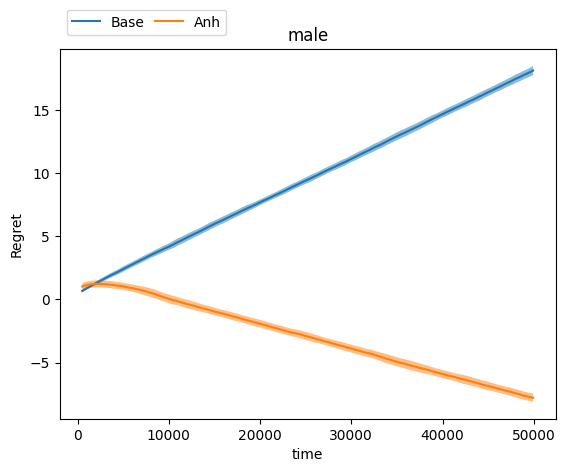

female 50066


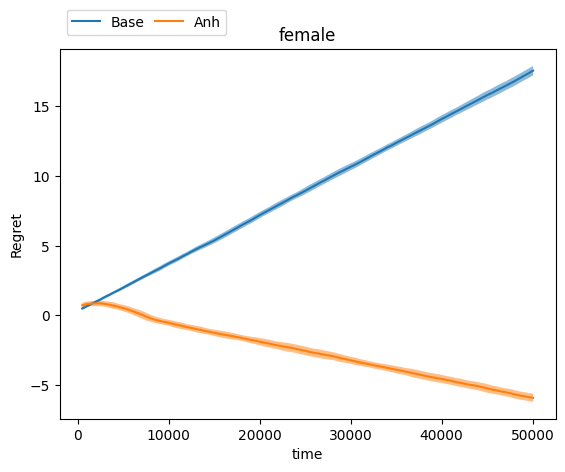

white 60891


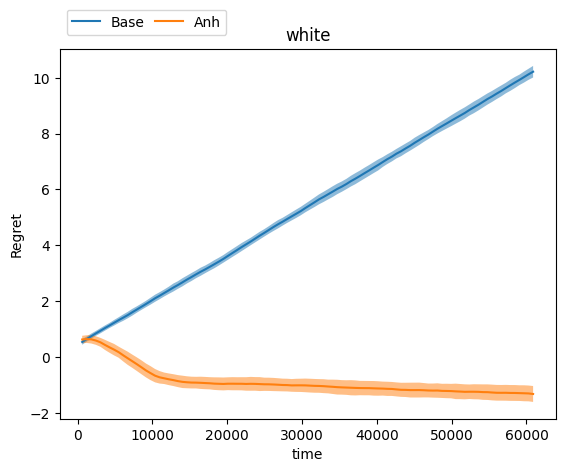

black 11931


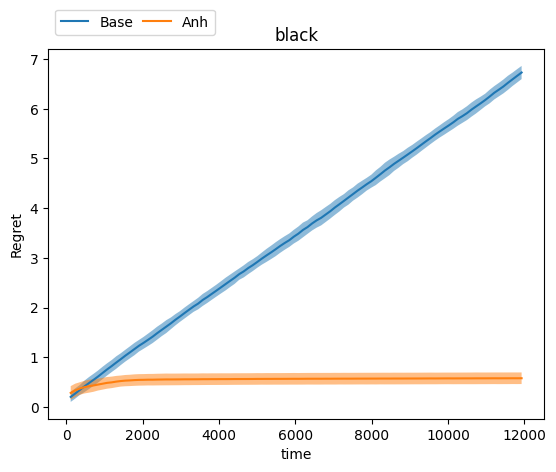

two-or-more 10194


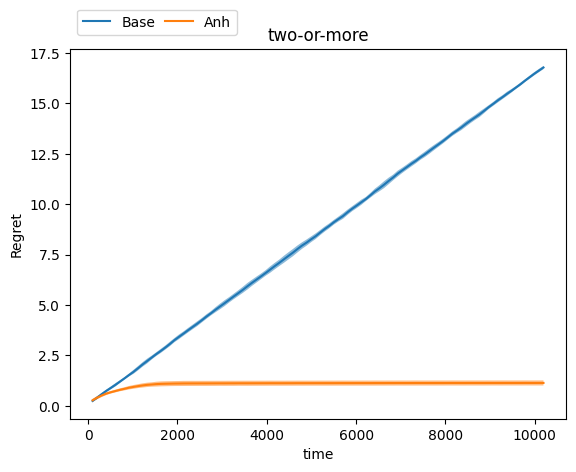

some-other 7932


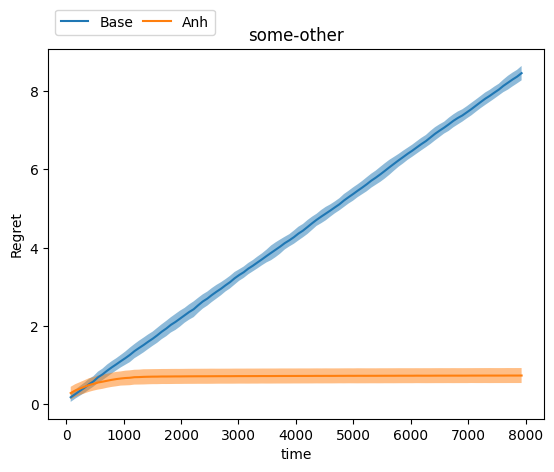

asian 6018


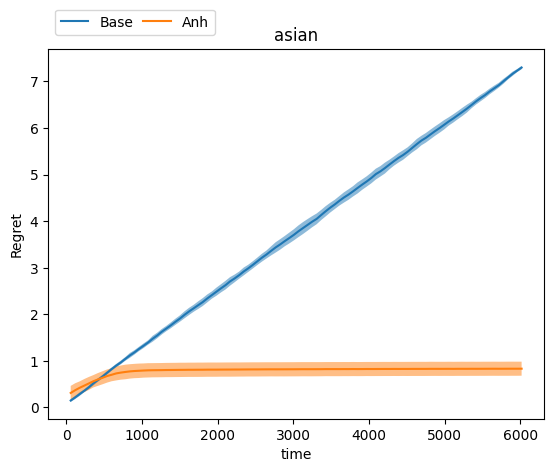

native-am 3034


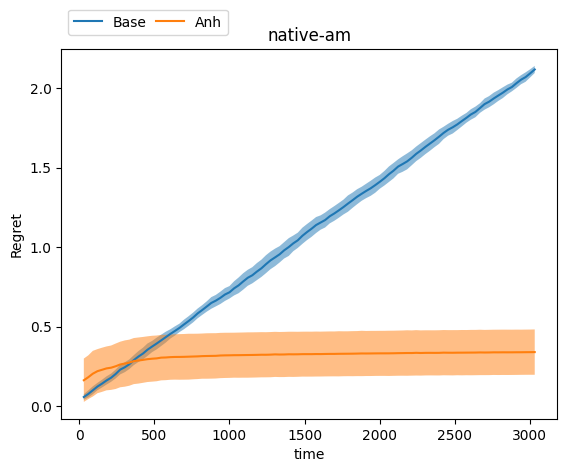

always_on 100000


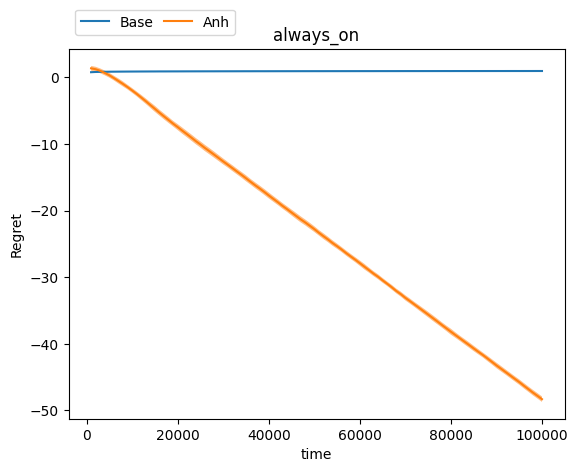

male 49934


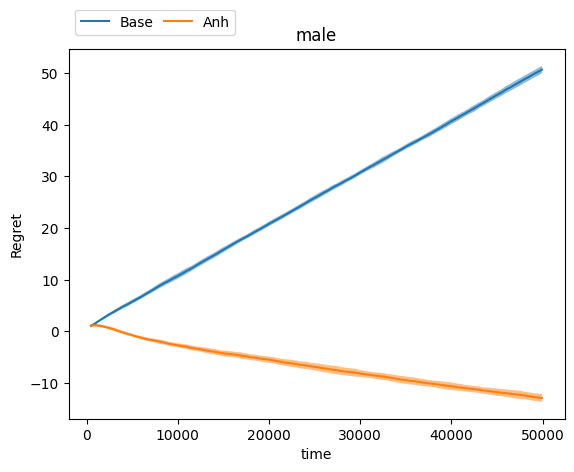

female 50066


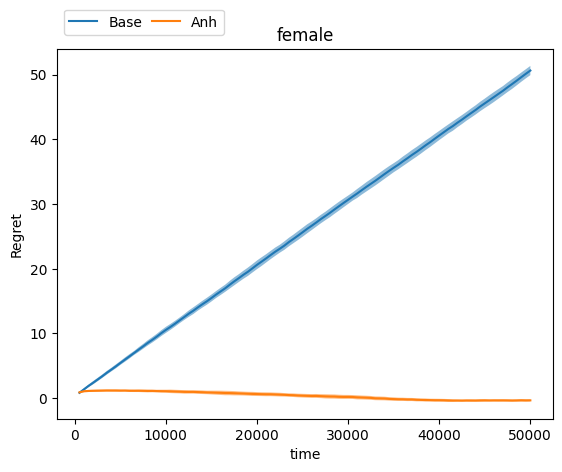

white 60891


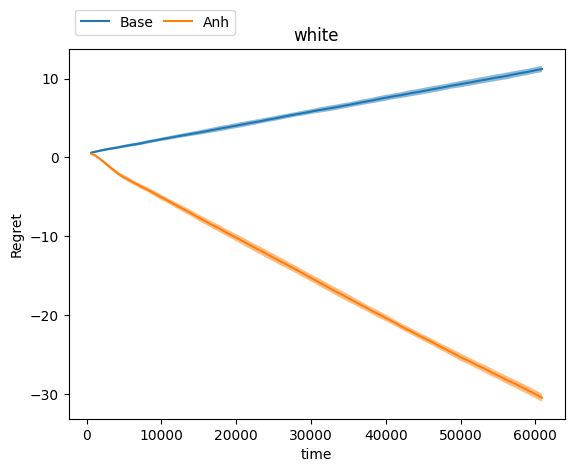

black 11931


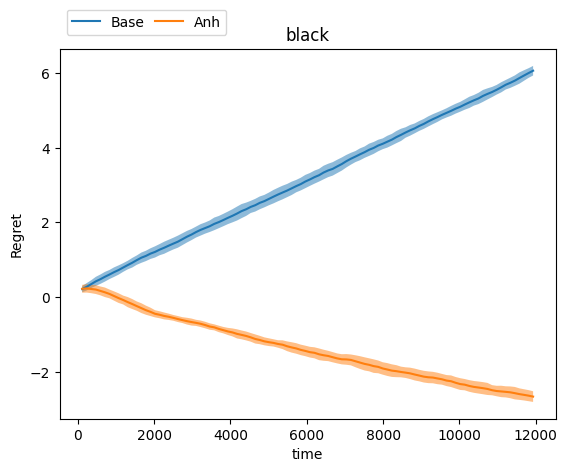

two-or-more 10194


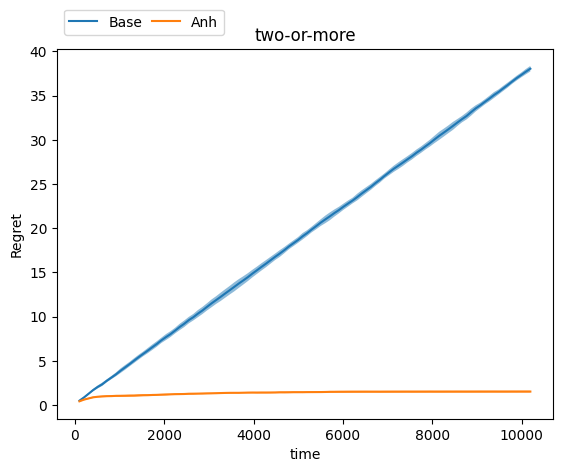

some-other 7932


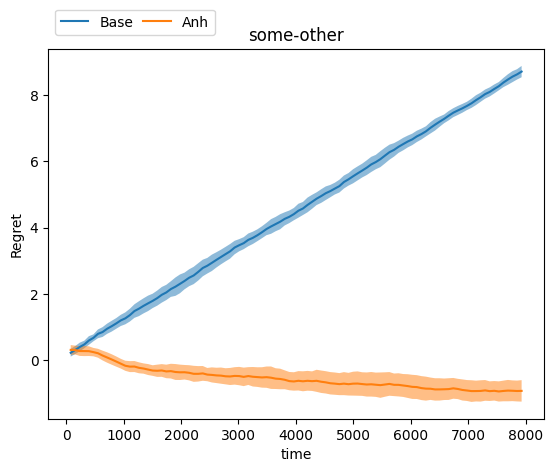

asian 6018


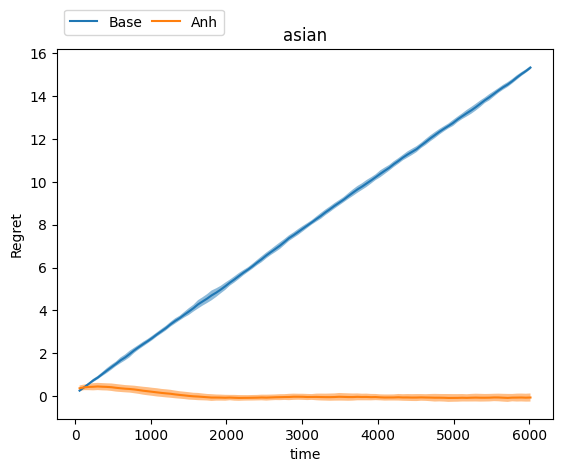

native-am 3034


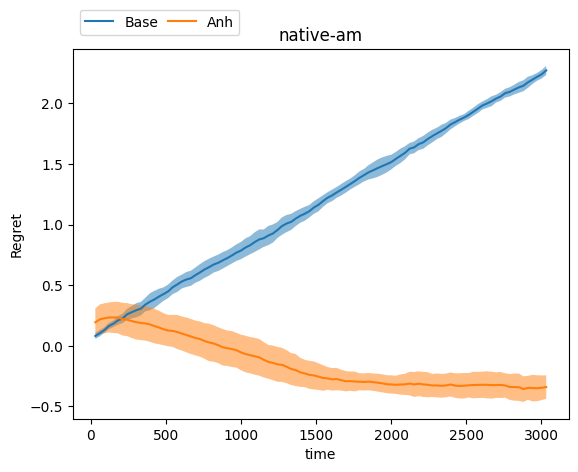

always_on 100000


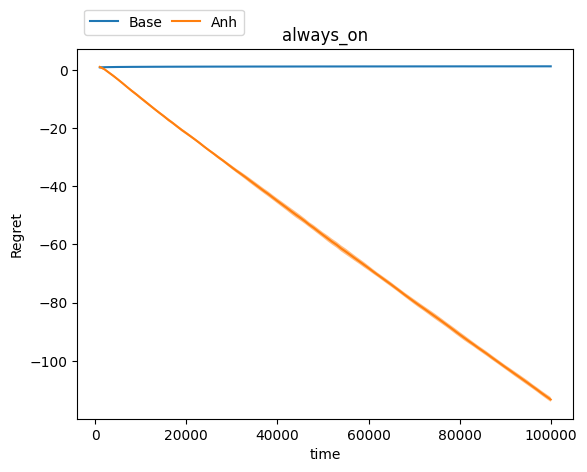

male 49934


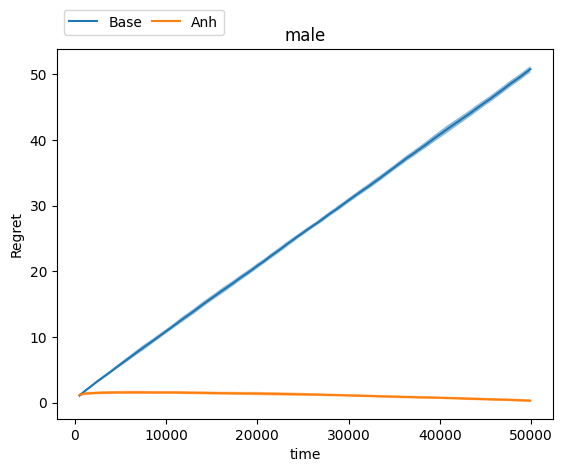

female 50066


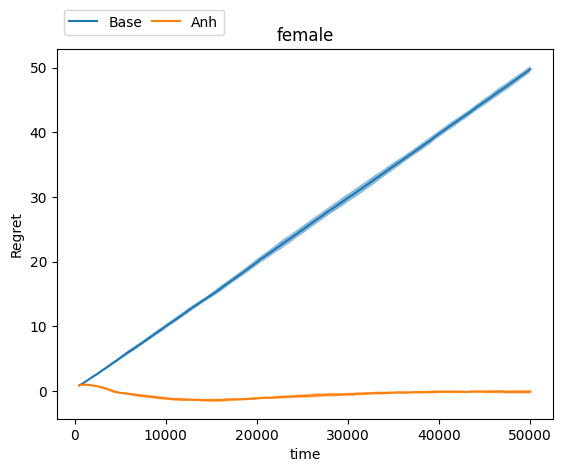

white 60891


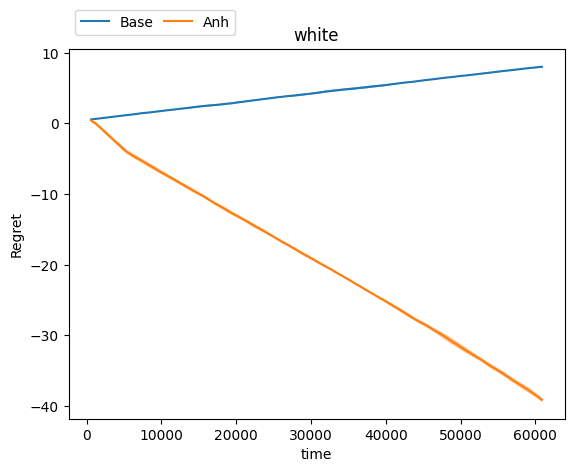

black 11931


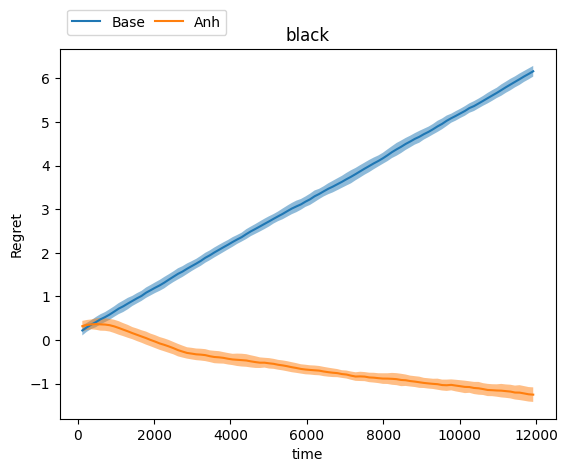

two-or-more 10194


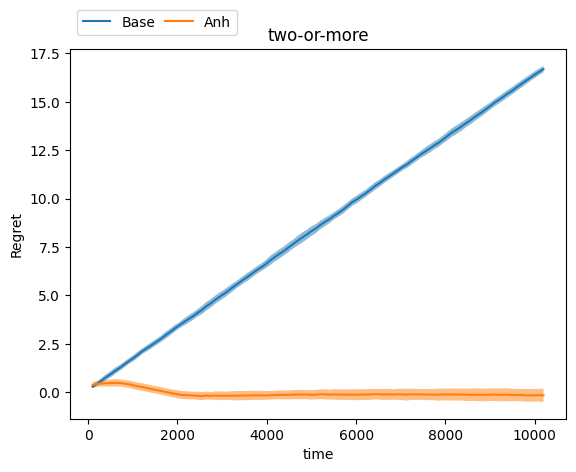

some-other 7932


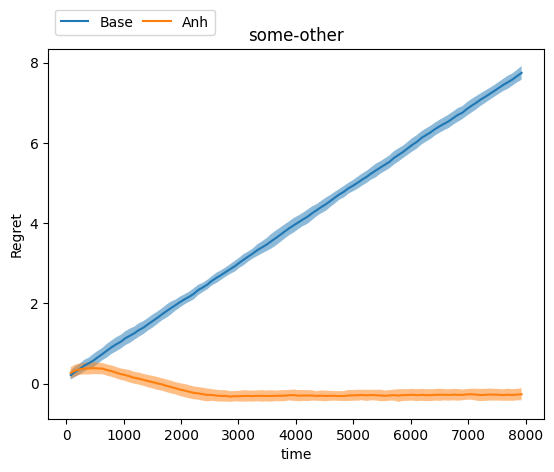

asian 6018


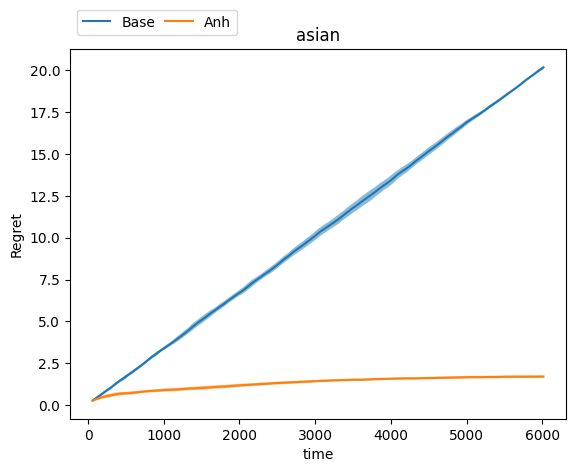

native-am 3034


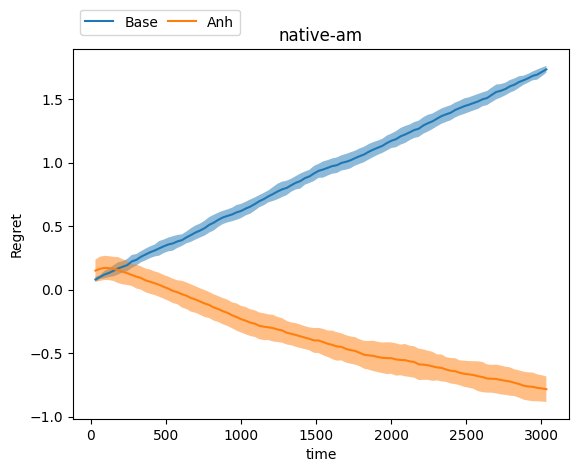

always_on 100000


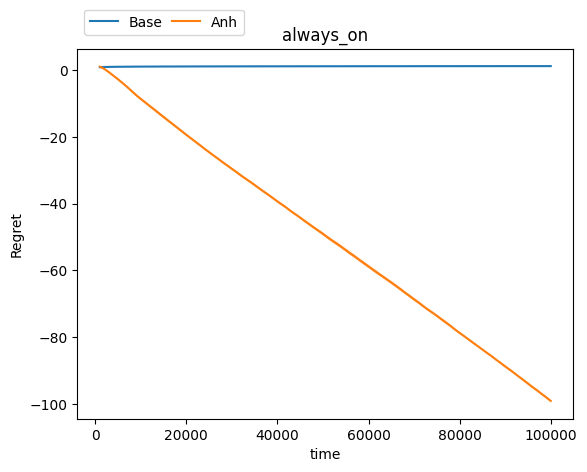

male 49934


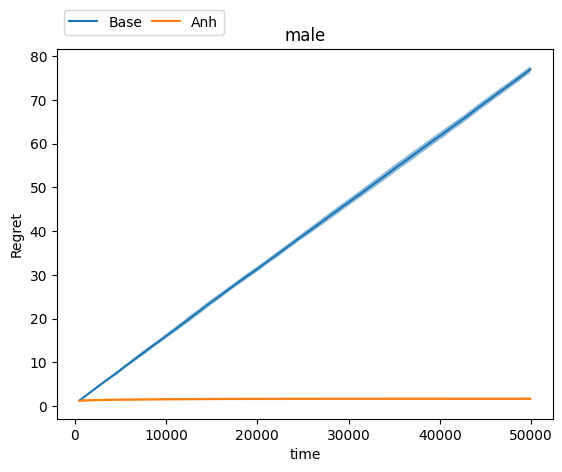

female 50066


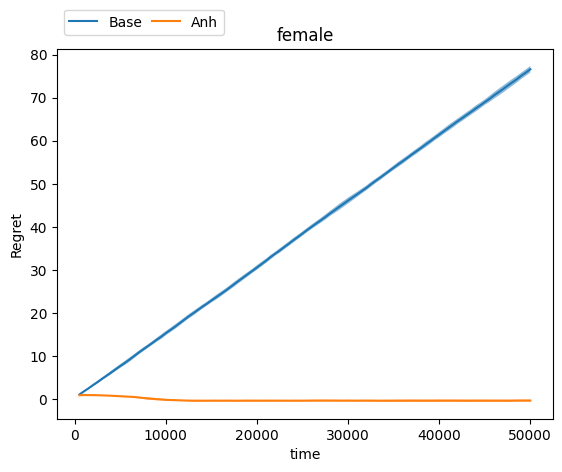

white 60891


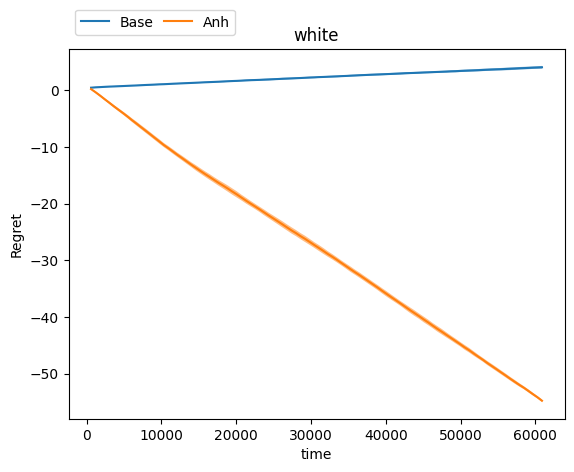

black 11931


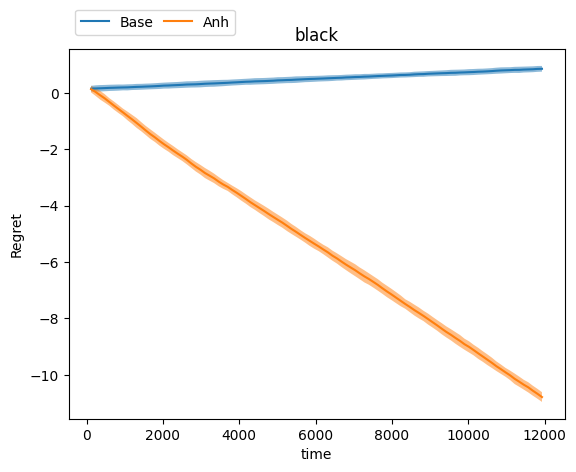

two-or-more 10194


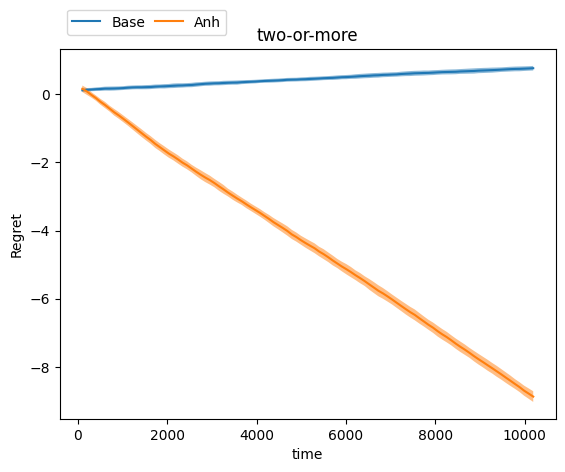

some-other 7932


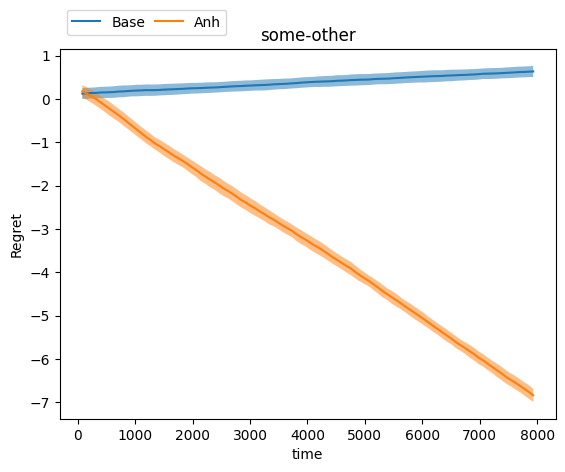

asian 6018


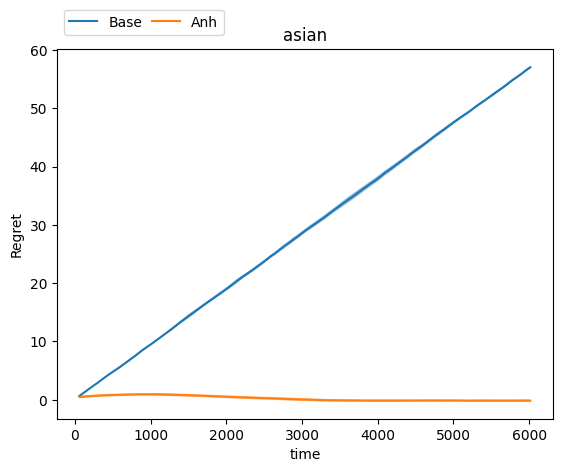

native-am 3034


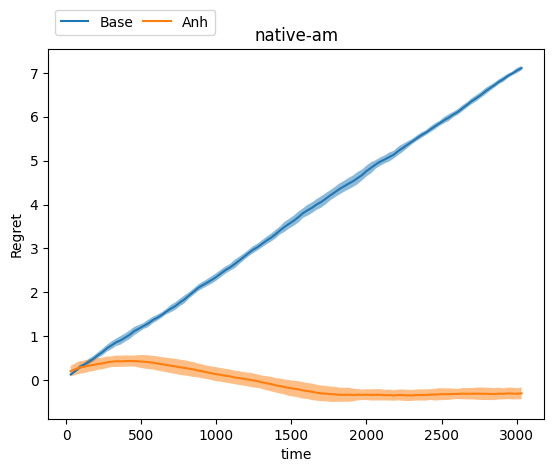

always_on 100000


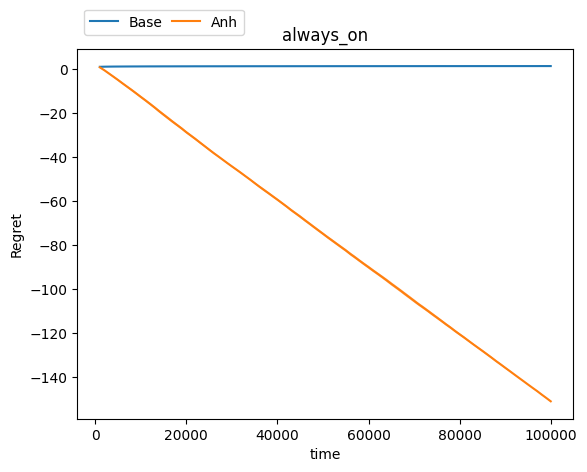

In [34]:
ds_mean = load_ob('syn_ymean_seeds.pickle')
plot_regret_curve_with_std(ds_mean, 'synth_ymean_alt')

ds_min = load_ob('syn_ymin_seeds.pickle')
plot_regret_curve_with_std(ds_min, 'synth_ymin_alt')

ds_max = load_ob('syn_ymax_seeds.pickle')
plot_regret_curve_with_std(ds_max, 'synth_ymax_alt')

ds_dperm = load_ob('syn_ydperm_seeds.pickle')
plot_regret_curve_with_std(ds_dperm, 'synth_ydperm_alt')